# Backtesting with intermittent refitting

[Forecasting for machine learning](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook we will show how to do **backtesting with a intermittent refitting** on both **single and multiple time series** using a **direct and recursive forecasting** strategy. We will also have **exogenous features** and try both a **expanding training window** and **rolling training window**. We will use the `skforecast` package to help us do this.

To obtain a robust estimate of the model's predictive capacity, a backtesting process is carried out. The process of backtesting consists of evaluating the performance of a predictive model by applying it retrospectively to historical data. Therefore, it is a special type of cross-validation applied to the previous period(s).

Note: Since recording the videos, skforecast have made breaking changes to their API in newer versions (>= 0.14). This notebook has been updated for use with skforecast version 0.14 and above, which are the versions with a new API. If you are using older versions of skforecast (<0.14) see the migration guide here: https://skforecast.org/0.14.0/user_guides/migration-guide.html

**Backtesting with intermittent refit**

The model is retrained every $n$ iterations of predictions.

![image](./images/backtesting_intermittent_refit.gif)

Image from [skforecast documentation](https://github.com/JoaquinAmatRodrigo/skforecast/blob/master/docs/img/backtesting_intermittent_refit.gif)

This notebook is adapted from the [skforecast example notebook](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html).



## Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Single time series

## Data


A time series is available with the monthly expenditure (millions of dollars) on corticosteroid drugs that the Australian health system had between 1991 and 2008. The data comes with two simulated exogenous variables. The data used in the examples of this document have been obtained from the magnificent book [Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

In [2]:
from skforecast.datasets import fetch_dataset

In [3]:
# Load the data
data = fetch_dataset(name="h2o_exog", raw=True)
data.head()

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199


The column `date` has been stored as a `string`. To convert it to `datetime` the `pd.to_datetime()` function can be use. Once in `datetime` format, and to make use of **Pandas** functionalities, it is set as an index. Also, since the data is monthly, the frequency is set as Monthly Started 'MS'.

In [4]:
# Data preparation
data = data.rename(columns={"fecha": "date"})
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data = data.set_index("date")
data = data.asfreq("MS")
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


When using the `asfreq()` method in Pandas, any gaps in the time series will be filled with `NaN` values to match the specified frequency. Therefore, it is essential to check for any missing values that may occur after this transformation.

In [5]:
# Check for missing values
print(f"Number of rows with missing values: {data.isnull().any(axis=1).sum()}")

Number of rows with missing values: 0


Text(0.5, 1.0, 'Monthly expenditure ($AUD) on corticosteroid drugs')

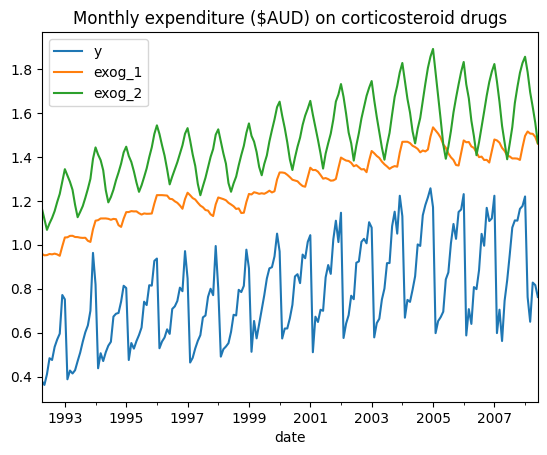

In [6]:
# Plot data
ax = data.plot()
ax.set_title("Monthly expenditure ($AUD) on corticosteroid drugs")

## Model (direct forecasting)

In [7]:
# Single time series forecasters (direct)
from skforecast.direct import ForecasterDirect

# Preprocessing and features
from sklearn.preprocessing import StandardScaler

# Traditional machine learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

With the `ForecasterDirect` class, a forecasting model is created and trained using a `RandomForestRegressor` regressor with a time window of 6 lags. This means that the model uses the previous 6 months as predictors.

In [8]:
# Create forecaster
steps = 7  # Number of steps to forecast

forecaster = ForecasterDirect(
    regressor=Ridge(alpha=1),
    lags=6,
    steps=steps,
    transformer_y=StandardScaler(),  # Scaling helpful for
    transformer_exog=StandardScaler(),  # linear models.
)

## Backtesting

![image](./images/backtesting_intermittent_refit.gif)

Image from [skforecast documentation](https://github.com/JoaquinAmatRodrigo/skforecast/blob/master/docs/img/backtesting_intermittent_refit.gif)


In [9]:
from skforecast.model_selection import backtesting_forecaster, TimeSeriesFold

Note: The argument needed to achieve this configuration is `refit=n`, where n
 is an integer. This configuration also allows the use of `fixed_train_size` to implement a rolling training window.

In [10]:
# Backtesting

# Forecast horizon & number of steps to move forecast origin
steps = 7

# Number of datapoints to test over
n_backtesting = steps * 3

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Refit the model every `refit` steps
refit = 2

# Define how time series will be split during backtesting
cv = TimeSeriesFold(
    steps                 = steps,
    initial_train_size    = initial_train_size,
    skip_folds            = None,
    refit                 = refit,
    fixed_train_size      = False,
    allow_incomplete_fold = True,
)

# Run backtesting
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    cv=cv,
    metric="mean_squared_error",
    verbose=True,
    show_progress=True,
)

print(f"Backtest metric (MSE): {metric}")

Information of folds
--------------------
Number of observations used for initial training: 174
Number of observations used for backtesting: 21
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2006-10-01 00:00:00 -- 2007-04-01 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2007-05-01 00:00:00 -- 2007-11-01 00:00:00  (n=7)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2007-11-01 00:00:00  (n=188)
    Validation: 2007-12-01 00:00:00 -- 2008-06-01 00:00:00  (n=7)



  0%|          | 0/3 [00:00<?, ?it/s]

Backtest metric (MSE):    mean_squared_error
0            0.012116


In [11]:
metric

,mean_squared_error
0,0.012116


In [12]:
predictions.head()

,pred
2006-10-01,1.128978
2006-11-01,1.117235
2006-12-01,1.088585
2007-01-01,1.072753
2007-02-01,0.923374


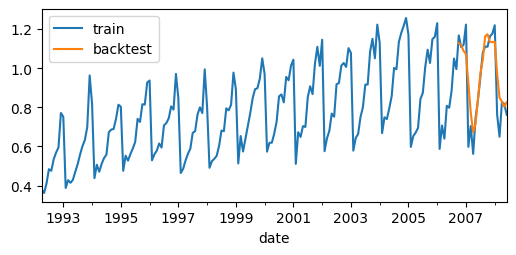

In [13]:
fig, ax = plt.subplots(figsize=(6, 2.5))
data["y"].plot(ax=ax, label="train")
predictions["pred"].plot(ax=ax, label="backtest")
ax.legend();

In [14]:
from sklearn.metrics import mean_squared_error

error_mse = mean_squared_error(
    y_true=data["y"].loc[predictions.index], y_pred=predictions
)

print(f"Test error (MSE) {error_mse}")

Test error (MSE) 0.012116099182152859


## Custom error metric

In the backtesting (`backtesting_forecaster`) and hyperparameter optimization (`grid_search_forecaster`) processes, besides the frequently used metrics such as `mean_squared_error` or `mean_absolute_error`, it is possible to use any custom function as long as:

+ It includes the arguments:

    + `y_true`: true values of the series.

    + `y_pred`: predicted values.

+ It returns a numeric value (`float` or `int`).

+ The metric is reduced as the model improves. Only applies in the `grid_search_forecaster` function if `return_best=True` (train the forecaster with the best model).

It allows evaluating the predictive capability of the model in a wide range of scenarios, for example:

+ Consider only certain months, days, hours...

+ Consider only dates that are holidays.

+ Consider only the last step of the predicted horizon.

The following example shows how to calculate the mean average percentage error (MAPE) which is: 

$$
100*\frac{1}{N}\sum_i{|\frac{y_i - \hat{y}_i}{y_i }}|
$$

In [15]:
# Custom metric
def custom_metric(y_true, y_pred):
    """
    Calculate the MAPE
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
# Backtesting
# Number of datapoints to test over
n_backtesting = steps * 3

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Define how time series will be split during backtesting
cv = TimeSeriesFold(
    steps                 = steps,
    initial_train_size    = initial_train_size,
    skip_folds            = None,
    refit                 = refit,
    fixed_train_size      = False,
    allow_incomplete_fold = True,
)

# Run backtesting
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    cv=cv,
    metric=custom_metric,
    verbose=True,
    show_progress=True,
)

print(f"Backtest metric (MAPE): {metric}")

Information of folds
--------------------
Number of observations used for initial training: 174
Number of observations used for backtesting: 21
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2006-10-01 00:00:00 -- 2007-04-01 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2007-05-01 00:00:00 -- 2007-11-01 00:00:00  (n=7)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2007-11-01 00:00:00  (n=188)
    Validation: 2007-12-01 00:00:00 -- 2008-06-01 00:00:00  (n=7)



  0%|          | 0/3 [00:00<?, ?it/s]

Backtest metric (MAPE):    custom_metric
0       9.715044


In [17]:
predictions.head()

,pred
2006-10-01,1.128978
2006-11-01,1.117235
2006-12-01,1.088585
2007-01-01,1.072753
2007-02-01,0.923374


# Multiple independent time series

Data has been obtained from [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data), specifically `train.csv`. This dataset contains 913,000 sales transactions from 2013–01–01 to 2017–12–31 for 50 products (SKU) in 10 stores. The goal is to predict the next 7 days sales for 50 different items in one store using the available 5 years history.

## Data

In [18]:
from skforecast.datasets import fetch_dataset

# Load the data
data = fetch_dataset(name="store_sales", raw=True)
data.head()

store_sales
-----------
This dataset contains 913,000 sales transactions from 2013-01-01 to 2017-12-31
for 50 products (SKU) in 10 stores.
The original data was obtained from: inversion. (2018). Store Item Demand
Forecasting Challenge. Kaggle. https://kaggle.com/competitions/demand-
forecasting-kernels-only
Shape of the dataset: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


`ForecasterRecursiveMultiSeries` equires that each time series is a column in the dataframe and that the index is time-like (datetime or timestamp). 

So now we process the data to get dataframes in the required format.

In [19]:
# Data preprocessing

selected_store = 2
selected_items = data.item.unique()  # All items
# selected_items = [1, 2, 3, 4, 5] # Selection of items to reduce computation time

# Filter data to specific stores and products
mask = (data["store"] == selected_store) & (data["item"].isin(selected_items))
data = data[mask].copy()

# Convert `date` column to datetime
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")

# Convert to one column per time series
data = pd.pivot_table(data=data, values="sales", index="date", columns="item")

# Reset column names
data.columns.name = None
data.columns = [f"item_{col}" for col in data.columns]

# Explicitly set the frequency of the data to daily.
# This would introduce missing values for missing days.
data = data.asfreq("1D")

# Sort by time
data = data.sort_index()

data.head(4)

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0,41.0,19.0,21.0,4.0,34.0,39.0,49.0,28.0,51.0,...,11.0,25.0,36.0,12.0,45.0,43.0,12.0,45.0,29.0,43.0
2013-01-02,16.0,33.0,32.0,14.0,6.0,40.0,47.0,42.0,21.0,56.0,...,19.0,21.0,35.0,25.0,50.0,52.0,13.0,37.0,25.0,57.0
2013-01-03,16.0,46.0,26.0,12.0,12.0,41.0,43.0,46.0,29.0,46.0,...,23.0,20.0,52.0,18.0,56.0,30.0,5.0,45.0,30.0,45.0
2013-01-04,20.0,50.0,34.0,17.0,16.0,41.0,44.0,55.0,32.0,56.0,...,15.0,28.0,50.0,24.0,57.0,46.0,19.0,32.0,20.0,45.0


In [20]:
# Check if any missing values introduced
data.isnull().sum().any()

False

/var/folders/xw/0ks6s8x53lvf4p3xdqzfh9300000gn/T/ipykernel_20319/762125342.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


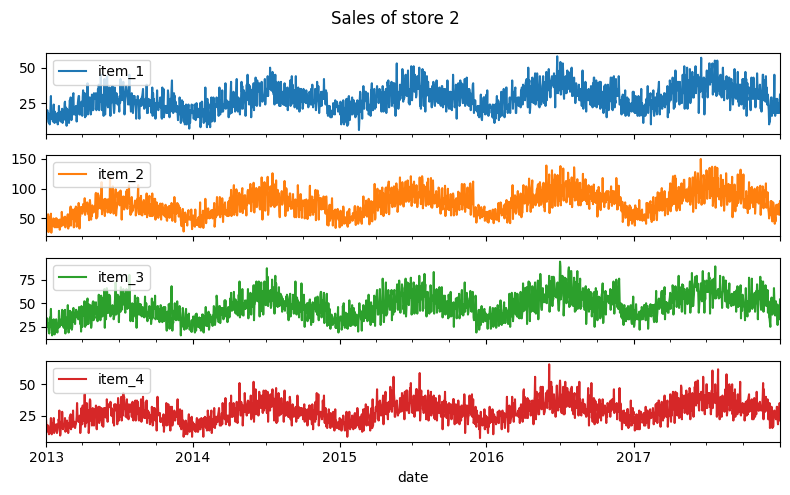

In [21]:
# Plot a subset of the time series
fig, ax = plt.subplots(figsize=(8, 5))
data.iloc[:, :4].plot(
    legend=True,
    subplots=True,
    sharex=True,
    title="Sales of store 2",
    ax=ax,
)
fig.tight_layout();

Let's add the day of the week to use as an exogenous feature.

In [22]:
data["day_of_week"] = data.index.weekday

## Model (Independent time series and recursive forecasting)

In [23]:
# Preprocessing and features
from sklearn.preprocessing import StandardScaler

# Traditional machine learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Multiple independent series forecasting (recursive)
from skforecast.recursive import ForecasterRecursiveMultiSeries

In [24]:
# Define parameters of a lightgbm
params_lgbm = {
    "n_estimators": 100,
    "learning_rate": 0.01,
    "max_depth": 10,
    "random_state": 8520,
    "verbose": -1,
}
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(**params_lgbm),
    lags=31,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

## Backtesting

![image](./images/backtesting_intermittent_refit.gif)

Image from [skforecast documentation](https://github.com/JoaquinAmatRodrigo/skforecast/blob/master/docs/img/backtesting_intermittent_refit.gif)


In [25]:
from skforecast.model_selection import backtesting_forecaster_multiseries

Note: The argument needed to achieve this configuration is `refit=n`, where n
 is an integer. This configuration also allows the use of `fixed_train_size` to implement a rolling training window.

In [26]:
# Define column names of target variables
target_cols = data.filter(like="item_").columns

# Define column names of exogenous features
exog_features = ["day_of_week"]

# Forecast horizon & number of steps to move forecast origin
steps = 7

# Number of datapoints to test over
n_backtesting = steps * 10

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Intermittent refitting steps
refit = 2

# Define how time series will be split during backtesting
cv = TimeSeriesFold(
    steps                 = steps,
    initial_train_size    = initial_train_size,
    skip_folds            = None,
    refit                 = refit,
    fixed_train_size      = True, # Rolling window
    allow_incomplete_fold = True,
)

# Run backtesting
metric, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data[target_cols],
    exog=data[exog_features],
    cv=cv,
    metric="mean_absolute_error",
    verbose=True,
    show_progress=True,
)

Information of folds
--------------------
Number of observations used for initial training: 1756
Number of observations used for backtesting: 70
    Number of folds: 10
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2013-01-01 00:00:00 -- 2017-10-22 00:00:00  (n=1756)
    Validation: 2017-10-23 00:00:00 -- 2017-10-29 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2017-10-30 00:00:00 -- 2017-11-05 00:00:00  (n=7)
Fold: 2
    Training:   2013-01-15 00:00:00 -- 2017-11-05 00:00:00  (n=1756)
    Validation: 2017-11-06 00:00:00 -- 2017-11-12 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2017-11-13 00:00:00 -- 2017-11-19 00:00:00  (n=7)
Fold: 4
    Training:   2013-01-29 00:00:00 -- 2017-11-19 00:00:00  (n=1756)
    Validation: 2017-11-20 00:00:00 -- 2017-11-26 00:00:00  (n=7)
Fold: 5
    T

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
metric

,levels,mean_absolute_error
0,item_1,5.853344
1,item_2,10.262317
2,item_3,7.756503
3,item_4,4.409974
4,item_5,4.431566
5,item_6,11.219436
6,item_7,10.742657
7,item_8,12.818735
8,item_9,11.027741
9,item_10,14.014020


In [28]:
predictions

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
2017-10-23,25.737237,71.449806,44.612733,27.985086,20.502012,70.897538,69.771604,92.463259,59.596422,90.095253,...,25.411417,44.226452,62.074166,34.644670,95.418690,68.550455,26.816172,63.552023,34.744635,80.557597
2017-10-24,29.833728,78.222084,47.863669,30.223092,23.846608,81.101308,75.395119,101.414598,65.675092,99.495692,...,27.209453,48.876699,69.355873,38.670701,104.566377,75.350416,25.442990,63.047178,38.108531,91.165574
2017-10-25,28.932057,79.293198,48.524143,30.766179,24.939102,79.670819,78.825871,103.960999,66.522894,99.010083,...,28.488135,51.541063,72.152019,40.750618,105.705947,76.936010,28.457739,68.861941,38.509712,90.213680
2017-10-26,28.941630,79.761730,50.467077,30.502513,23.759288,84.047934,77.619879,108.194348,71.598860,99.051868,...,30.635815,52.383542,72.690756,40.172576,112.042478,80.048329,30.144650,69.111509,39.352040,88.757690
2017-10-27,31.929698,83.778940,52.465810,32.781559,25.918478,85.343851,82.112766,111.743041,70.871406,104.098285,...,32.373300,54.272874,71.453091,42.213106,109.561393,83.882891,31.997189,74.774544,40.553626,93.189072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,24.596912,64.192343,44.050449,26.958247,19.408012,70.256172,66.499686,91.713752,58.613013,87.236347,...,24.763900,41.488877,60.592064,35.248412,98.409048,70.235278,27.488115,61.851122,34.958182,75.563242
2017-12-28,24.446495,70.936348,48.780823,24.950216,22.207857,75.997737,69.786731,93.291592,60.271386,90.362106,...,25.390033,43.182665,62.225368,35.824796,97.658828,72.949440,25.660241,64.412299,34.331887,80.373182
2017-12-29,28.266079,74.972355,46.571595,27.289215,22.956295,72.976525,72.736184,97.666716,62.160450,94.677992,...,24.133394,44.971154,64.143339,39.964524,104.352974,71.011720,28.261616,67.814124,36.826629,85.397000
2017-12-30,28.003804,74.934001,51.812931,28.918673,24.422845,74.859590,76.371509,99.642724,66.562613,100.423928,...,27.662150,48.196335,67.699179,39.528285,105.298744,78.006741,29.801160,69.388078,37.231587,86.853537


Let's compute the mean absolute error over all the data points.

In [29]:
from sklearn.metrics import mean_absolute_error

custom_metric(
    y_true=data[target_cols].loc[predictions.index],
    y_pred=predictions,
)

17.07948880292624

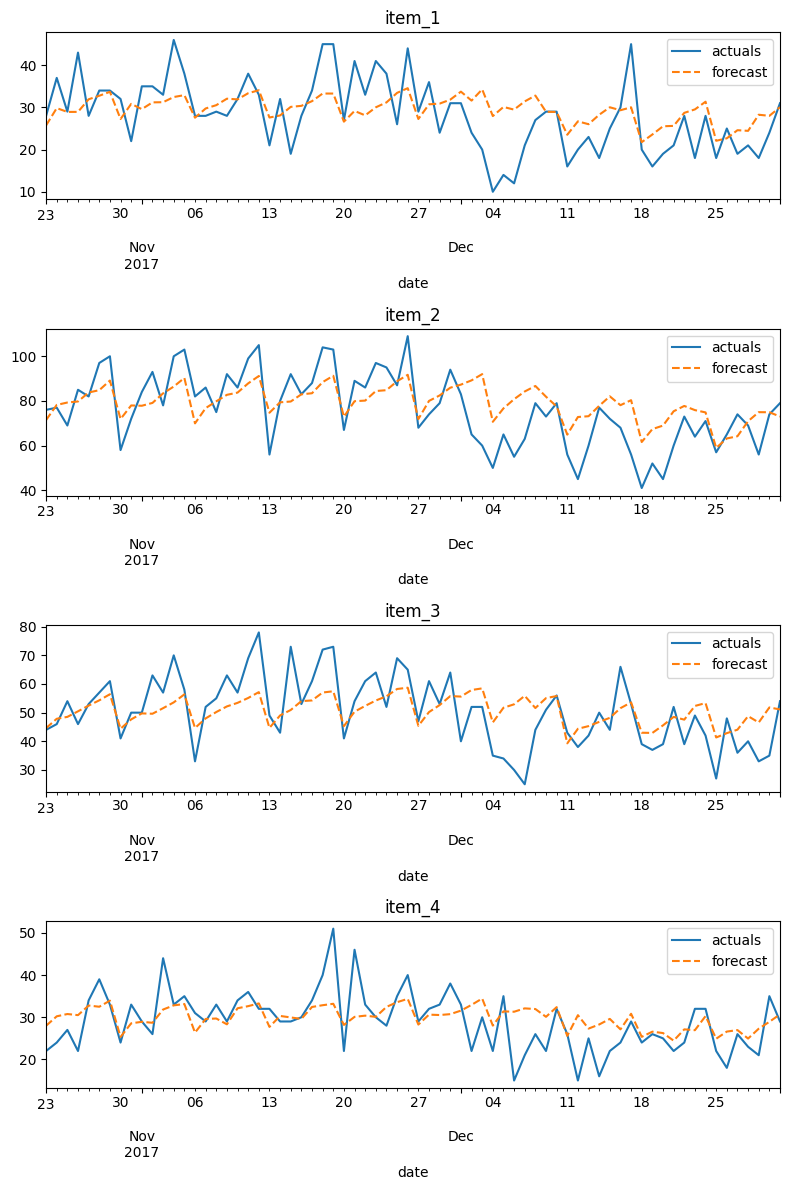

In [30]:
# Plot predictions
num_timeseries = 4
fig, axs = plt.subplots(nrows=num_timeseries, figsize=(8, 3*num_timeseries))
for i in range(4):
    timeseries = data.columns[i]
    data.iloc[-len(predictions):, i].plot(
        legend=True,
        label="actuals",
        ax=axs[i],
    )
    predictions.iloc[:, i].plot(
        legend=True,
        label="forecast",
        linestyle="--",
        ax=axs[i],
    )
    axs[i].set_title(f"{timeseries}")
    fig.tight_layout();